# Confidence Intervals

This work was heavily inspired and lead by the Feldman-Cousins article on _A Unified Approach to the Classical Statistical Analysis of Small Signals_ available on the arXiv:physics/9711021.  Interested readers are also referred to the PDG review 36 on statistical methods, in particular 36.3 Intervals and Limits.

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
sns.set_style('white')
from scipy import stats
import numpy as np

In [14]:
np.set_printoptions(precision=3, suppress=True, linewidth=112)

Let's model a system which occurs frequently in astroparticle physics: you measure a source of events with a known background (techniques for estimation of background are another topic) and unknown source strength.  You want to determine, under the assumption of a poisson source, what is the limit on the Poisson µ given your observed number of events Nobs.

To study this case, let's construct a model object.  The object conceptually generates a matrix of numbers given a background rate $\mu_b$ as input.  The abcissa represents the number of events observed, and the ordinate the Poission mean of the the signal.  Any cell of the table will then include the Poisson probability density function for $P(N\;|\;\mu_s + \mu_b)$

In [151]:
class PoissonModel(object):
    """
    Model an experiment with 
        nb: background level poisson mean
        no: range of observations
        ns: range of signal
        ss: signal scaling
    """
    # Bug - this should be a base class from which specific models are derived by overriding __call__ method
    def __init__(self, nb, no, ns, ss):
        self.nb = nb
        self.no = no
        self.ns = ns
        self.ss = ss
        self.table = np.zeros((self.ns, self.no), 'd')
        for j in range(self.ns):
            for i in range(self.no):
                self.table[j, i] = self(j, i)      
             
    def __call__(self, s, o):
        "Implement poisson with background"
        mu = self.ss * s + self.nb
        if mu == 0.0:
            if o == 0.0: 
                return 1.0
            else:
                return 0.0
        return stats.poisson.pmf(o, mu)
    
    def ucl(self, cl):
        "Returns upper confidence limit for given CL"
        xmin = np.zeros(self.ns, 'd')
        a = 1.0 - cl
        for j in range(self.ns):
            psum = 0.0
            for i in range(self.no):
                psum += self.table[j, i]
                if psum > a:
                    xmin[j] = i
                    break
        return np.arange(self.ns) * self.ss, xmin
                    
    def ccl(self, cl):
        "Returns centered confidence intervals for a given CL"
        xmin = np.zeros(self.ns, 'd')
        xmax = self.no * np.ones(self.ns, 'd')
        a = 0.5*(1.0 - cl)
        for j in range(self.ns):
            psum = 0.0
            ista = 0
            for i in range(self.no):
                psum += self.table[j, i]
                if psum > a and ista == 0:
                    xmin[j] = i
                    ista = 1
                if psum > 1 - a:
                    xmax[j] = i
                    break
        return np.arange(self.ns) * self.ss, xmin, xmax
    
    def feldman_cousins(self, cl):
        "Returns confidence intervals according to Feldman Cousins construction"
        xmax = np.zeros(self.ns, 'i')
        xmin = np.array([self.no] * self.ns)
        # First, calculate the table of FC likelihood ratios FCLR[:,i] = T[:,i] / L_best[i]
        FCLR = np.zeros((self.ns, self.no), 'd')
        for i in range(self.no):
            L_best = max(self.table[:, i])
            FCLR[:, i] = self.table[:, i] / L_best

        # Now implement the FC ordering principle
        for j in range(self.ns):
            # Make 3-tuple (LR, P, obs index), sort on LR
            fco = np.array(list(zip(FCLR[j, :], self.table[j, :], range(self.no))))
            fco.sort()
            fco = np.array(list(reversed(fco)))
            
            psum = 0.0
            # print "Doing index", j, fco
            for r, p, i in fco:
                psum += p
                xmin[j] = min(xmin[j], i)
                xmax[j] = max(xmax[j], i)
                if psum >= cl: break
                    
        return FCLR, np.arange(self.ns) * self.ss, xmin, xmax
                
    def __str__(self):
        txt = ""
        for j in range(self.ns-1, -1, -1):
            txt += "%6.2f:" % (j * self.ss)
            for i in range(self.no):
                txt += " %5.3f" % self.table[j, i]
            txt += "\n"
        return txt
        
    def plot(self, **kwargs):
        X = np.arange(self.no)
        Y = np.arange(self.ns) * self.ss
        plt.contourf(X, Y, self.table, levels=np.linspace(0, np.amax(self.table), 10), **kwargs), plt.grid()
        
    def plot_cdf(self, **kwargs):
        X = np.arange(self.no)
        Y = np.arange(self.ns) * self.ss
        plt.contourf(X, Y, np.cumsum(self.table, 1), levels=np.linspace(0, 1, 21), **kwargs), plt.grid()

In [152]:
pm = PoissonModel(0.0, 10, 25, 0.2)
#fco = pm.feldman_cousins(0.9)
fclr, y, x0, x1 = pm.feldman_cousins(0.9)

In [ ]:
fclr, y, x0, x1 = pm.feldman_cousins(0.9)

In [81]:
pm = PoissonModel(0.0, 10, 25, 0.2)

Note for this special case an important number to remember.  For a poisson process with no significant background, the implication of observing zero events is that the $\mu_{90}$ (that is the 90% CL frequentist upper limit) is 2.3.  What does this mean?  Note that this does __not__ say that I believe with a 90% chance of being right that the signal has got to be less than 2.3.  Think about trying to write a toy simulation code to test this.  How would you select signal strengths?  This is just not given.  You can certainly play with hidden distributions of signals and see what happens.  What this says really is that _assuming_ that the source µ is 2.3, then 90% of the experiments will have 0 (or less).  If you had a stronger source then getting 0 events is even less likely but that is not quantifiable. 

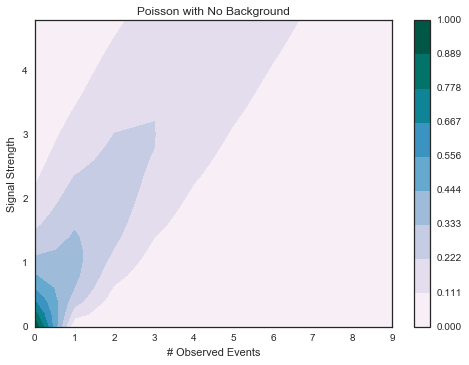

In [73]:
pm.plot(colors=None, cmap=cm.get_cmap('PuBuGn')), plt.colorbar()
plt.xlabel('# Observed Events')
plt.ylabel('Signal Strength')
plt.title('Poisson with No Background')

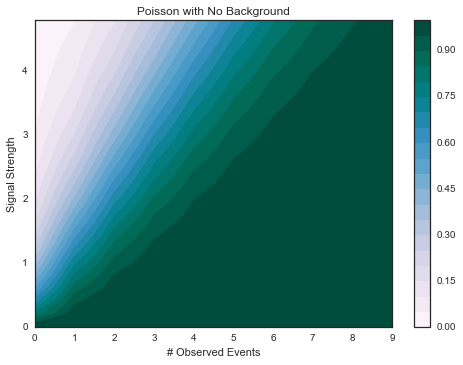

In [74]:
pm.plot_cdf(colors=None, cmap=cm.get_cmap('PuBuGn')), plt.colorbar()
plt.xlabel('# Observed Events')
plt.ylabel('Signal Strength')
plt.title('Poisson with No Background')

In [75]:
pm = PoissonModel(3.0, 25, 200, 0.1)

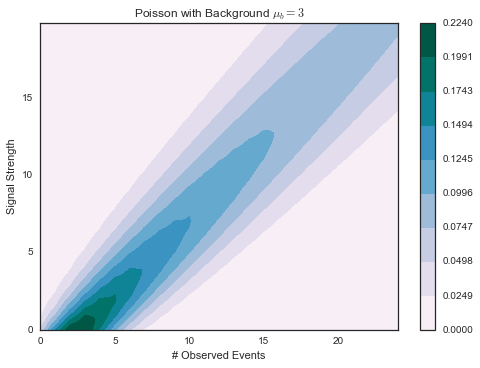

In [76]:
pm.plot(colors=None, cmap=cm.get_cmap('PuBuGn')), plt.colorbar()
plt.xlabel('# Observed Events')
plt.ylabel('Signal Strength')
plt.title('Poisson with Background $\mu_b = 3$')

In [77]:
y, xul = pm.ucl(0.9)
y, xcl, xch = pm.ccl(0.9)

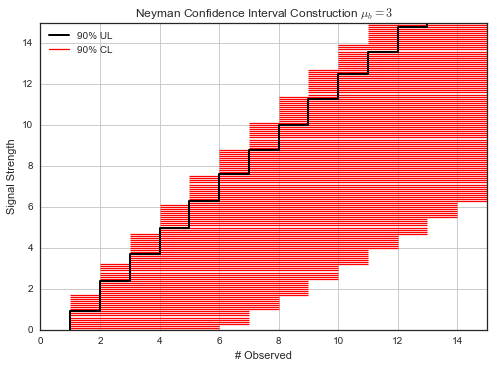

In [78]:
plt.plot(xul, y, 'k', linewidth=2, linestyle='steps', label='90% UL')
plt.hlines(y, xcl, xch, 'r', linewidth=1.25, label='90% CL')
plt.grid(), plt.axis([0,15,0,15]), plt.legend(loc='upper left')
plt.xlabel('# Observed'), plt.ylabel('Signal Strength')
plt.title('Neyman Confidence Interval Construction $\mu_b = 3$')

There are a couple of things to note with this C.I. construct.  First, note the case of zero observed events.  There is no corresponding C.I. - it is empty.  In the case of a continuous distribution such as a Gaussian, the C.I. would have smoothly descenced through zero and become something which included negative signal means.  However, for Poission there is no concept of a negative mean.  

The other problem with the UL or Centered C.I. is that the edges depend on the choice of UL or Centered - and _this choice must be made a priori to performing the analysis_.  Feldman and Cousins describe the statistical consequences of "flip-flopping" _a posteriori_: under-coverage.

## Feldman-Cousins Method

For these reasons, Feldman and Cousins devise a _unified_ method for choosing the confidence interval based on an ordering of likelihood ratios.  First they compute the likelihood ratio

$$R = \frac{P(x\;|\;\mu)}{P(x\;|\;\mu_\mathrm{best})}$$

They then order the # observered axis for a given signal strength row based on this ratio and keep selecting elements until the original probability exceeds the CL.  This constructs a confidence band as shown in the figure below.  Note that the case of zero observations is 'fixed' and additionally, the data analyzer does not have to choose _a priori_ to select the UL or Centered - there is just one choice.

In [153]:
fclr, y, x0, x1 = pm.feldman_cousins(0.9)

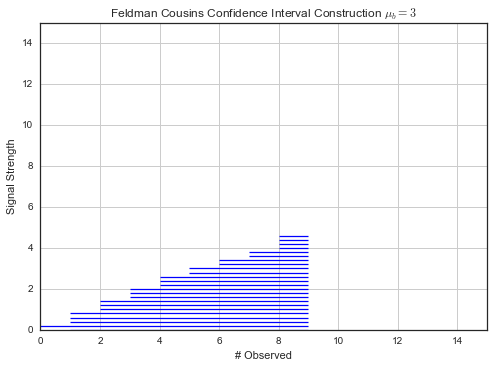

In [154]:
plt.hlines(y, x0, x1, 'b', linewidth=1.25), plt.grid(), plt.axis([0,15,0,15])
plt.xlabel('# Observed'), plt.ylabel('Signal Strength')
plt.title('Feldman Cousins Confidence Interval Construction $\mu_b = 3$')